# didtool介绍

didtool是由部门内专门用于特征工程和建模的一套工具包，封装了一些常用的操作，用以满足日常建模需求，规范化建模流程并提高建模效率。

didtool主要包含以下几个功能：
- 特征预处理
- 特征分箱
- 特征分析
- 特征筛选
- 样本切分
- 模型训练&评估
- 评分卡映射

安装：
```
pip install didtool
```
```
conda install didtool
```
更新：
```
pip install -U didtool
```
```
conda install -U didtool
```

使用：

In [1]:
import datetime
import time
import os

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
import didtool
print("didtool:", didtool.__version__)

Duplicate key in file PosixPath('/data0/anaconda3_35/envs/anaconda_yangfan_3_35/lib/python3.7/site-packages/matplotlib/mpl-data/matplotlibrc'), line 252 ('font.family:  sans-serif')
Duplicate key in file PosixPath('/data0/anaconda3_35/envs/anaconda_yangfan_3_35/lib/python3.7/site-packages/matplotlib/mpl-data/matplotlibrc'), line 402 ('axes.unicode_minus: True  # use Unicode for the minus symbol rather than hyphen.  See')


didtool: 0.1.1


# 特征预处理
特征预处理主要是针对离散变量的编码和变换，常见的处理方式为:
- One-hot编码
- 序号编码
- WOE变换
- 列表特征处理

## One-hot编码
`OneHotTransformer`: 将类别特征转换成one-hot特征，其中nan单独分箱，如果指定了最大类别数N，超出topN的类别将被分入others

方法：
- `fit`: 学习输入数据中各个列的类别
- `transform`: 将数据按类别展开成one-hot特征
- `fit_transform`: fit + transform

示例：

In [8]:
# 原始数据
df

,brand,constellation
0,Apple,NaN
1,huawei,水瓶座
2,NaN,NaN
3,NaN,NaN
4,zte,巨蟹座
...,...,...
995,Apple,NaN
996,huawei,NaN
997,huawei,NaN
998,NaN,NaN


In [9]:
onehot_tran = didtool.OneHotTransformer()
onehot_tran.fit(df, max_bins=3)  # max_bins=3，表示只取计数最多的前3个类别，剩下的则划入others类别，nan单独划分一类
onehot_tran.transform(df)

,brand_Apple,brand_huawei,brand_oppo,brand_others,brand_nan,constellation_天秤座,constellation_双鱼座,constellation_巨蟹座,constellation_others,constellation_nan
0,1,0,0,0,0,0,0,0,0,1
1,0,1,0,0,0,0,0,0,1,0
2,0,0,0,0,1,0,0,0,0,1
3,0,0,0,0,1,0,0,0,0,1
4,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
995,1,0,0,0,0,0,0,0,0,1
996,0,1,0,0,0,0,0,0,0,1
997,0,1,0,0,0,0,0,0,0,1
998,0,0,0,0,1,0,0,0,0,1


## 序号编码
`CategoryTransformer`: 将类别特征转换成数字编码的category特征，其中nan单独分箱，如果指定了最大类别数N，超出topN的类别将被分入others

编码规则如下：
- TOP N类别：分别用1~N编码
- nan类别：编码为0
- others类别：编码为N（others编码和最后一个类别的编码相同，主要是为了避免训练集中others不存在的情况）

方法：
- `fit`: 学习输入数据中各个列的类别
- `transform`: 将数据按类别转换成数字编码
- `fit_transform`: fit + transform

示例：

In [10]:
# 原始数据
df

,brand,constellation
0,Apple,NaN
1,huawei,水瓶座
2,NaN,NaN
3,NaN,NaN
4,zte,巨蟹座
...,...,...
995,Apple,NaN
996,huawei,NaN
997,huawei,NaN
998,NaN,NaN


In [11]:
category_tran = didtool.CategoryTransformer()
category_tran.fit(df, max_bins=10)  # max_bins=10，表示只取计数最多的前10个类别，剩下的划入others类别，nan单独划分一类
category_tran.transform(df)

,brand,constellation
0,1,0
1,2,9
2,0,0
3,0,0
4,10,3
...,...,...
995,1,0
996,2,0
997,2,0
998,0,0


类别编码之后，可以查看类别编码映射关系，并选择导出文件，方便上线后做编码映射处理

In [12]:
category_tran.df_encoder

,brand,brand_encoder,constellation,constellation_encoder
0,Apple,1,天秤座,1
1,huawei,2,双鱼座,2
2,oppo,3,巨蟹座,3
3,xiaomi,4,摩羯座,4
4,vivo,5,射手座,5
5,honor,6,狮子座,6
6,samsung,7,金牛座,7
7,meizu,8,白羊座,8
8,lenovo,9,水瓶座,9
9,smartisan,10,双子座,10


## WOE变换
`WOETransformer`: 将特征转换成woe值，如果是连续变量，能先进行分箱后再编码成对应分箱的woe值

参数：
- `cut_method`: 对连续值采用的分箱方式，默认为'dt'——决策树分箱
- `n_bins`: 对连续值的分箱个数，默认为10

方法：
- `fit`: 学习输入数据的woe映射关系
- `transform`: 将数据转换成woe值
- `fit_transform`: fit + transform

示例：

In [14]:
# 原始数据
df['brand'] = df['brand'].astype('category')  # 对于类别型变量，需显示转换成category类型
df

,brand,age,label
0,Apple,41.0,0
1,huawei,36.0,1
2,NaN,34.0,0
3,NaN,NaN,0
4,zte,42.0,0
...,...,...,...
995,Apple,21.0,0
996,huawei,43.0,0
997,huawei,33.0,0
998,NaN,27.0,1


In [15]:
woe_tran = didtool.WOETransformer(cut_method='dt', n_bins=5)
woe_tran.fit(df[['brand', 'age']], df['label'])
woe_tran.transform(df[['brand', 'age']])

,brand,age
0,0.342123,-0.259737
1,-0.453328,-0.259737
2,-0.342922,-0.259737
3,-0.342922,-1.293633
4,0.957659,-0.259737
...,...,...
995,0.342123,0.271892
996,-0.453328,-0.259737
997,-0.453328,-0.259737
998,-0.342922,0.650929


In [16]:
# woe编码之后，可以查看编码映射关系
woe_tran.woe_df

,var_name,bin_value,bin_range,group_count,group_rate,positive_count,positive_rate,woe,iv_list,var_iv
0,brand,360,[360],1,0.001,0,0.000000,0.957659,0.001833,0.173994
1,brand,Apple,[Apple],362,0.362,77,0.212707,0.342123,0.047408,0.173994
2,brand,coolpad,[coolpad],1,0.001,0,0.000000,0.957659,0.001833,0.173994
3,brand,honor,[honor],24,0.024,4,0.166667,0.041368,0.000042,0.173994
4,brand,htc,[htc],1,0.001,0,0.000000,0.957659,0.001833,0.173994
5,brand,huawei,[huawei],184,0.184,20,0.108696,-0.453328,0.032298,0.173994
6,brand,lenovo,[lenovo],2,0.002,0,0.000000,0.264512,0.000191,0.173994
7,brand,meizu,[meizu],3,0.003,0,0.000000,-0.140953,0.000066,0.173994
8,brand,nan,[nan],292,0.292,35,0.119863,-0.342922,0.030495,0.173994
9,brand,nubia,[nubia],1,0.001,0,0.000000,0.957659,0.001833,0.173994


## 列表特征处理
`ListTransformer`: 可以将列表值展开成多维特征

例如：
- "0,1,4" -> [1,1,0,0,1]
- "0:10,1:5,4:20" -> [10,5,0,0,20]

参数：
- `sep`: 一级列表分割符，默认为','
- `sub_sep`: 二级列表分割符，默认为None

方法：
- `fit`: 学习输入数据中共有多少列
- `transform`: 将数据展开成多维特征
- `fit_transform`: fit + transform

Tips：
- fit参数可以指定`max_bins`限制展开后的维度，按频数取前`max_bins`列
- 原始列为NaN，则展开后所有维度取值均为NaN，保持缺失值逻辑一致

示例：

### 处理一级列表
展开后的特征取值为0/1，即multi-hot编码

In [17]:
# 原始数据
df

,interest_lev_1
0,"军事,旅游出行,美食,时事"
1,"财经,娱乐明星,星座命理,情感两性,时事"
2,"数码,母婴育儿,时事"
3,NaN
4,"读书作家,人文艺术,美女帅哥,搞笑幽默,情感两性"
...,...
995,"互联网,体育,时尚,数码,时事"
996,"读书作家,人文艺术,美食"
997,"汽车,时尚,美食,搞笑幽默,时事"
998,"时尚,家装家居,美妆,美食,设计美学"


In [18]:
list_trans = didtool.ListTransformer(sep=',')
list_trans.fit_transform(df, max_bins=10)  # 指定max_bins=10，只取频数最高的前10列

,interest_lev_1_体育,interest_lev_1_娱乐明星,interest_lev_1_情感两性,interest_lev_1_搞笑幽默,interest_lev_1_数码,interest_lev_1_时事,interest_lev_1_时尚,interest_lev_1_美女帅哥,interest_lev_1_美食,interest_lev_1_财经
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
995,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0
996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
997,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
998,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


### 处理二级列表

In [21]:
# 原始数据
df.head()

,category_list
0,"78:54.37,40:54.84,1:98.01,24:78.17"
1,"4:88.44,14:87.57,2:59.99,1:96.07,56:95.78,37:7..."
2,"72:88.53,1:59.77,75:98.28"
3,NaN
4,"91:87.98,14:62.21,2:62.97,17:51.68,5:83.07,54:..."


In [22]:
list_trans = didtool.ListTransformer()
list_trans.fit_transform(df, sep=',', sub_sep=':', max_bins=10)  # 指定max_bins=10，只取频数最高的前10列

,category_list_1,category_list_14,category_list_17,category_list_2,category_list_24,category_list_28,category_list_37,category_list_4,category_list_5,category_list_8
0,98.01,0.00,0.00,0.00,78.17,0.00,0.00,0.00,0.00,0.00
1,96.07,87.57,0.00,59.99,0.00,0.00,75.68,88.44,0.00,0.00
2,59.77,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.00,62.21,51.68,62.97,0.00,0.00,0.00,0.00,83.07,0.00
...,...,...,...,...,...,...,...,...,...,...
995,87.82,0.00,0.00,0.00,0.00,69.68,0.00,51.40,54.38,69.19
996,0.00,0.00,0.00,0.00,97.68,0.00,0.00,0.00,0.00,0.00
997,75.74,0.00,0.00,82.98,85.30,0.00,0.00,70.36,0.00,77.02
998,0.00,0.00,0.00,0.00,77.45,0.00,0.00,0.00,0.00,90.15


# 特征分箱
特征分箱是针对连续值的分箱处理，实现连续值到离散值的映射

方法：
- `cut`: 自动分箱，返回分箱编码
    - `x`: 输入数据
    - `method`: 采用的分箱方式，默认为'dt'
        - `"step"`: 等距分箱
        - `"quantile"`: 等频分箱
        - `"dt"`: 决策树分箱
        - `"lgb"`: LightGBM分箱
        - `"chi"`: 卡方分箱
    - `n_bins`: 分箱数，默认为10
    - `target`: 目标分类（用于有监督分箱），默认为None
    - `return_bins`: 是否返回分箱切割点，默认为False
    - `nan`: 如果有NaN，分箱编码的取值，默认为-1
- `cut_with_bins`: 指定切分点分箱，返回分箱编码
    - `x`: 输入数据
    - `bins`: 分箱分割点
    - `right`: 默认为True，表示分箱区间为左开右闭，如(1,2],(2,3]，反之为左闭右开


In [23]:
# 原始数据
df

,age,label
0,41.0,0
1,36.0,1
2,34.0,0
3,NaN,0
4,42.0,0
...,...,...
995,21.0,0
996,43.0,0
997,33.0,0
998,27.0,1


## 等距分箱

In [24]:
res, bins = didtool.cut(df['age'], method='step', n_bins=10, return_bins=True)
print('res[:20]:', res[:20])
print('bins:', bins)

res[:20]: [ 4  4  3 -1  5  4  2  2  0 -1  6  0  7  1  4  2  2  4  1  2]
bins: [-inf, 13.1, 20.2, 27.299999999999997, 34.4, 41.5, 48.599999999999994, 55.699999999999996, 62.8, 69.9, inf]


## 等频分箱


In [25]:
res, bins = didtool.cut(df['age'], method='quantile', n_bins=10, return_bins=True)
print('res[:20]:', res[:20])
print('bins:', bins)

res[:20]: [ 8  7  6 -1  8  7  4  2  0 -1  9  0  9  0  8  3  2  8  0  2]
bins: [-inf  20.  22.  24.  26.  28.  30.  34.  38.  44.  inf]


## 决策树分箱

In [26]:
res, bins = didtool.cut(df['age'], target=df['label'],method='dt', n_bins=10, return_bins=True)
print('res[:20]:', res[:20])
print('bins:', bins)

res[:20]: [ 5  5  4 -1  5  5  3  2  0 -1  8  0  9  1  5  3  3  5  2  2]
bins: [-inf 13.  17.5 23.5 30.5 34.5 44.5 46.5 49.5 51.5  inf]


## LGB分箱

In [27]:
res, bins = didtool.cut(df['age'], target=df['label'],method='lgb', n_bins=10, return_bins=True)
print('res[:20]:', res[:20])
print('bins:', bins)

res[:20]: [ 7  7  6 -1  7  7  3  2  0 -1  8  0  9  1  7  3  3  7  2  2]
bins: [-inf 13.  17.5 23.5 27.5 30.5 32.5 34.5 44.5 52.5  inf]


## 卡方分箱

In [28]:
res, bins = didtool.cut(df['age'], target=df['label'], method='chi', n_bins=10, return_bins=True)
print('res[:20]:', res[:20])
print('bins:', bins)

res[:20]: [ 6  6  5 -1  6  6  4  3  1 -1  8  1  9  2  6  4  4  6  3  3]
bins: [-inf   9.  12.  18.  23.  30.  34.  44.  50.  51.  inf]


## 指定分割点分箱

In [29]:
res = didtool.cut_with_bins(df['age'], bins=[0,10,20,30,40,50,100])
print('res[:20]:', res[:20])

res[:20]: [ 4  3  3 -1  4  3  2  2  0 -1  5  1  5  1  3  2  2  4  1  2]


# 特征分析

## `iv_all`
计算全部特征的iv值

参数：
- `x`: 待计算iv值的DataFrame
- `y`: 目标值序列
- `exclude_col`: 需要排除的列名，默认为None

In [30]:
# 原始数据
df['brand'] = df['brand'].astype('category')
df

,age,brand,label
0,41.0,Apple,0
1,36.0,huawei,1
2,34.0,NaN,0
3,NaN,NaN,0
4,42.0,zte,0
...,...,...,...
995,21.0,Apple,0
996,43.0,huawei,0
997,33.0,huawei,0
998,27.0,NaN,1


In [31]:
iv_df = didtool.iv_all(df[['age', 'brand']], df['label'])
iv_df

,iv
feature,
age,0.540
brand,0.174


## `psi_all`
按月计算特征稳定性

参数;
- `data`: 需要计算psi值的DataFrame
- `features`: 指定`data`中哪些列需要计算psi
- `group_col`: 指定`data`中作为分组的列名，默认为"month"
- `expected_data`: 期望的数据，如果指定`expected_data`，每个月的psi值都和期望数据做比较，否则，每个月的psi值都是和上一个月做比较


In [32]:
# 原始数据
df['brand'] = df['brand'].astype('category')
df

,age,brand,month
0,41.0,Apple,2020-09
1,36.0,huawei,2020-11
2,34.0,NaN,2020-10
3,NaN,NaN,2020-11
4,42.0,zte,2020-06
...,...,...,...
995,21.0,Apple,2020-06
996,43.0,huawei,2020-11
997,33.0,huawei,2020-10
998,27.0,NaN,2020-06


In [33]:
# 不指定expected_data
psi_df = didtool.psi_all(df, ['age', 'brand'], group_col='month')
psi_df

,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11
age,NaN,0.175,0.289,0.518,0.230,0.372
brand,NaN,0.663,0.626,0.250,0.639,0.716


In [34]:
# 指定expected_data
psi_df = didtool.psi_all(df, ['age', 'brand'], group_col='month', expected_data=df[df.month<='2020-08'])
psi_df

,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11
age,0.054,0.195,0.044,0.432,0.691,0.186
brand,0.280,0.211,0.184,0.314,0.688,0.318


## 单特征woe分箱
`SingleWOETransformer`：对单特征做分箱，并计算woe和iv
参数；
- `cut_method`: 分箱方法，仅对连续值有效
- `n_bins`: 分箱数，仅对连续值有效

In [35]:
# 原始数据
df['brand'] = df['brand'].astype('category')
df

,age,brand,label
0,41.0,Apple,0
1,36.0,huawei,1
2,34.0,NaN,0
3,NaN,NaN,0
4,42.0,zte,0
...,...,...,...
995,21.0,Apple,0
996,43.0,huawei,0
997,33.0,huawei,0
998,27.0,NaN,1


In [36]:
# 连续值分箱分析
woe_transformer = didtool.SingleWOETransformer(cut_method='dt',n_bins=5)
col = 'age'
woe_transformer.fit(df[col], df['label'], var_name=col)
woe_transformer.woe_df.style.bar(color='lightblue', subset=['group_count'], align='zero').bar(color='#FFA07A', subset=['positive_rate'], align='zero')

,var_name,bin_value,bin_range,group_count,group_rate,positive_count,positive_rate,woe,iv_list,var_iv
0,age,-1,NA,180,0.180,9,0.050,-1.294,0.191,0.481
1,age,0,"(-inf, 17.5000]",36,0.036,2,0.056,-1.182,0.033,0.481
2,age,1,"(17.5000, 23.5000]",169,0.169,34,0.201,0.272,0.014,0.481
3,age,2,"(23.5000, 30.5000]",290,0.290,78,0.269,0.651,0.151,0.481
4,age,3,"(30.5000, 51.5000]",287,0.287,37,0.129,-0.260,0.018,0.481
5,age,4,"(51.5000, inf]",38,0.038,1,0.026,-1.960,0.074,0.481


In [37]:
# 离散值分箱分析，一个类别一个分箱
woe_transformer = didtool.SingleWOETransformer(cut_method='dt',n_bins=5)
col = 'brand'
woe_transformer.fit(df[col], df['label'], var_name=col)
woe_transformer.woe_df.style.bar(color='lightblue', subset=['group_count'], align='zero').bar(color='#FFA07A', subset=['positive_rate'], align='zero')

,var_name,bin_value,bin_range,group_count,group_rate,positive_count,positive_rate,woe,iv_list,var_iv
0,brand,360,[360],1,0.001,0,0.000,0.958,0.002,0.174
1,brand,Apple,[Apple],362,0.362,77,0.213,0.342,0.047,0.174
2,brand,coolpad,[coolpad],1,0.001,0,0.000,0.958,0.002,0.174
3,brand,honor,[honor],24,0.024,4,0.167,0.041,0.000,0.174
4,brand,htc,[htc],1,0.001,0,0.000,0.958,0.002,0.174
5,brand,huawei,[huawei],184,0.184,20,0.109,-0.453,0.032,0.174
6,brand,lenovo,[lenovo],2,0.002,0,0.000,0.265,0.000,0.174
7,brand,meizu,[meizu],3,0.003,0,0.000,-0.141,0.000,0.174
8,brand,nan,[nan],292,0.292,35,0.120,-0.343,0.030,0.174
9,brand,nubia,[nubia],1,0.001,0,0.000,0.958,0.002,0.174


# 特征筛选
建模之前需要对特征进行筛选，减少无关特征或冗余特征

`Selector`:

参数：
- `data`: 需要进行特征筛选的DataFrame
- `label`: 目标值序列

主要功能如下：
- `drop_missing`: 去除缺失率高的的特征
- `drop_low_iv`: 去除IV值低的特征
- `drop_correlated`: 去除线性相关性高的特征，如果两个特征高度线性相关，只保留IV值高的特征
- `drop_low_importance`: 使用特征进行预训练，查看各个特征的重要度排名，按照累计重要度阈值剔除得分较低的特征
- `plot_missing`: 画出所有特征的缺失率分布情况
- `plot_iv`: 画出TOP20特征的iv值
- `plot_correlated`: 画出特征相关度热力度
- `plot_importance`: 画出预训练时TOP20的特征重要度


可直接访问的属性：
- `missing_stats`: 各个特征的缺失率
- `iv_stats`: 各个特征的iv值
- `corr_matrix`: 各个特征间的pearson相关系数
- `record_correlated`: 记录drop_correlated中剔除的特征，以及对应的参考特征和相关系数
- `importance_stats`: 预训练时各个特征的重要度得分

In [43]:
# 原始数据
df.head()

,month,label,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,...,col_20,col_21,col_22,col_23,col_24,col_25,col_26,col_27,col_28,col_29
0,2020-09,0,1,2,2,2,4,1,1,NaN,...,0.0,0.00,0.00,0.00,0.00,-1,1.0,1,-1,4
1,2020-11,1,1,1,2,3,3,1,-1,36.0,...,0.0,40.20,10.75,28.13,1.33,-1,1.0,2,9,4
2,2020-10,0,1,2,2,-1,-1,1,-1,NaN,...,0.0,NaN,NaN,NaN,NaN,-1,1.0,0,-1,0
3,2020-11,0,1,1,1,-1,-1,1,-1,NaN,...,0.0,NaN,NaN,NaN,NaN,-1,1.0,0,-1,3
4,2020-06,0,1,1,1,3,3,1,1,41.0,...,0.0,0.86,0.00,0.86,0.00,-1,1.0,20,4,1


In [44]:
# 初始化，输入data和label
features = [col for col in df.columns.values if col not in ('month', 'label')]
selector = didtool.Selector(df[features], df['label'])

## drop_missing
过滤缺失率高的特征

参数：
- `missing_threshold`: 缺失率阈值，缺失率高于阈值的列将会被过滤
- `missing_value`: 除了NaN外，需要被当做缺失值处理的值，默认为None

In [45]:
selector.drop_missing(0.8)

1 features with greater than 0.80 missing values.



In [46]:
# 查看各特征的缺失率
selector.missing_stats.head(10)

,missing_rate
col_14,0.846
col_13,0.757
col_7,0.617
col_26,0.454
col_23,0.414
col_24,0.414
col_22,0.414
col_21,0.414
col_8,0.370
col_12,0.193


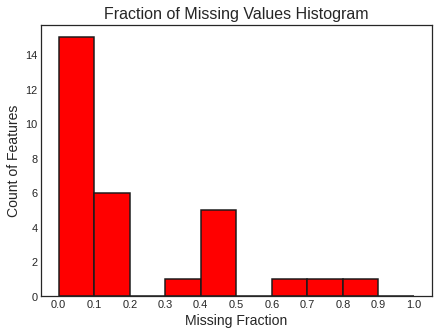

In [47]:
# 查看缺失率分布情况
selector.plot_missing()

## drop_low_iv
过滤iv值低的特征

参数：
- `iv_threshold`: iv阈值，iv值低于阈值的特征将会被过滤
- `**kwargs`: 可以指定计算iv时使用的分箱方法和分箱数

In [48]:
selector.drop_low_iv(0.02, cut_method='dt')

8 features with iv less than 0.020.



In [49]:
# 查看各列iv值
selector.iv_stats.head(10)

,iv
feature,
col_17,0.434
col_5,0.231
col_13,0.166
col_7,0.135
col_29,0.133
col_8,0.124
col_12,0.114
col_27,0.089
col_18,0.088


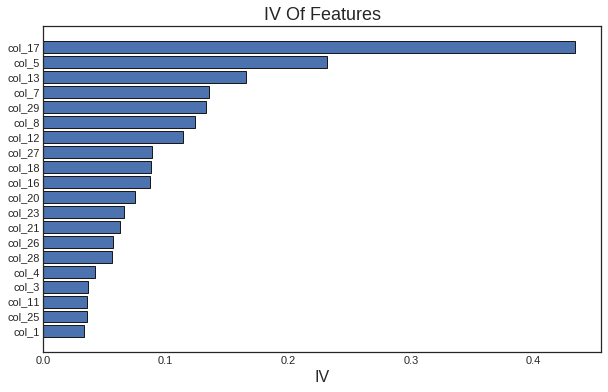

In [50]:
selector.plot_iv()

## drop_correlated
计算所有特征间的pearson相关系数，如果两个特征的相关系数高于阈值，则保留iv值高的特征，过滤iv值低的特征。

`TIPS`：建议调用此方法前先调用`drop_low_iv`计算出所有特征的iv值。如果iv值尚未计算，默认将自动调用`drop_low_iv(0)`

参数：
- `corr_threshold`: 相关系数阈值，如果一对特征的相关系数高于此阈值，则需要过滤其中一个特征

In [51]:
selector.drop_correlated(0.9)

1 features dropped with a correlation magnitude greater than 0.90.



In [52]:
selector.record_correlated.head(10)

,drop_feature,corr_feature,corr_value
0,col_21,col_23,0.946


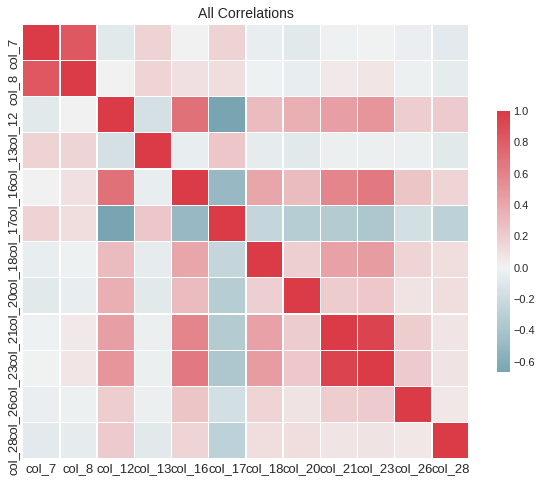

In [53]:
# 可以画出相关系数矩阵的热力图
selector.plot_correlated(plot_all=True)

## drop_low_importance
使用LightGBM进行多次训练（每次训练按4:1随机划分训练集验证集），计算所有特征的重要度贡献（单特征重要度得分/所有特征重要度总得分），只保留累计重要度达到`cumulative_importance`的特征，过滤重要度靠后的特征


参数：
- `cumulative_importance`: 累计重要度阈值，过滤超过此阈值的特征
- `run_times`: 训练次数，多次训练可以减小偏差，确保重要特征不会因为一次随机训练被筛除，默认为10

In [54]:
selector.drop_low_importance(0.95, run_times=10)

Training Gradient Boosting Model...
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[920]	valid_0's binary_logloss: 0.427925
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[997]	valid_0's binary_logloss: 0.427689
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's binary_logloss: 0.427946
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[919]	valid_0's binary_logloss: 0.427448
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[949]	valid_0's binary_logloss: 0.428311
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[998]	valid_0's binary_logloss: 0.427436
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iterati

In [55]:
selector.importance_stats

,feature,importance,normalized,cumulative
0,col_23,4560.5,0.157,0.157
1,col_7,3675.7,0.127,0.284
2,col_8,3525.9,0.122,0.406
3,col_16,2883.1,0.100,0.506
4,col_27,2345.7,0.081,0.587
5,col_28,1605.2,0.055,0.642
6,col_17,1296.5,0.045,0.687
7,col_12,1101.1,0.038,0.725
8,col_29,1038.5,0.036,0.761
9,col_26,1002.4,0.035,0.795


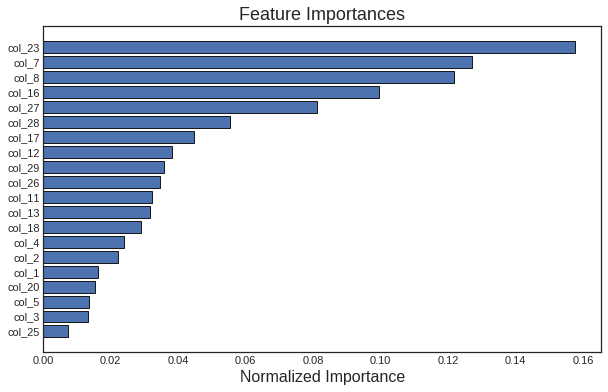

In [56]:
selector.plot_importance()

## 其他
上述几个drop命令，可以使用一行语句完成：

```
selector.drop_missing(0.8).drop_low_iv(0.02).drop_correlated(0.9).drop_low_importance(0.95)
```


**注意：** 执行完selector的drop操作之后，并不会对外部的数据产生变更，需要过滤的特征名保存在`selector.drop_cols`, 需要手动删除外部数据的相关特征

In [57]:
print("cols to drop:", selector.drop_cols)
df.drop(columns=selector.drop_cols, inplace=True)
df.head()

cols to drop: ['col_14', 'col_6', 'col_0', 'col_9', 'col_22', 'col_10', 'col_15', 'col_24', 'col_19', 'col_21', 'col_1', 'col_20', 'col_5', 'col_3', 'col_25']


,month,label,col_2,col_4,col_7,col_8,col_11,col_12,col_13,col_16,col_17,col_18,col_23,col_26,col_27,col_28,col_29
0,2020-09,0,2,4,NaN,41.0,7,4.0,0.0,4.0,1.0,0.0,0.00,1.0,1,-1,4
1,2020-11,1,2,3,36.0,36.0,0,4.0,0.0,7.0,1.0,0.0,28.13,1.0,2,9,4
2,2020-10,0,2,-1,NaN,34.0,-1,4.0,NaN,8.0,2.0,0.0,NaN,1.0,0,-1,0
3,2020-11,0,1,-1,NaN,NaN,0,3.0,NaN,1.0,3.0,0.0,NaN,1.0,0,-1,3
4,2020-06,0,1,3,41.0,42.0,7,4.0,0.0,5.0,1.0,0.0,0.86,1.0,20,4,1


# 样本切分
didtool提供了三个样本划分函数（**注意**：样本划分后返回的仍然是全量数据集，但是增加了一列`group_col`以区分不同的数据集）：

- `split_data`: 根据train_mask和val_mask分别划分训练集和验证集，剩下的为测试集
    - `data`: 输入数据
    - `train_mask`：训练集掩码
    - `val_mask`：验证集掩码
    - `group_col`：输出分组列，默认为'group'，训练集所属分组为0，验证集所属分组为1，测试集所属分组为-1
- `split_data_random`: 根据train_size和val_size，随机划分训练集和验证集，剩下的为测试集
    - `data`: 输入数据
    - `train_size`：训练集大小（0~1）
    - `val_size`：验证集大小（0~1）
    - `group_col`：输出分组列，默认为'group'，训练集所属分组为0，验证集所属分组为1，测试集所属分组为-1
    - `random_state`: 随机数种子，默认为None
- `split_data_stacking`: 根据oot_mask划分出训练集和OOT集，训练集再随机划分成n_fold份
    - `data`: 输入数据
    - `oot_mask`：OOT集掩码
    - `n_fold`：K折大小
    - `group_col`：输出分组列，默认为'group'，OOT集所属分组为-1，训练+验证集的分组为0~`n_fold`-1
    - `random_state`: 随机数种子，默认为None

In [58]:
# 按时间划分训练集、验证集、测试集
df = didtool.split_data(df, df.month <= "2020-08", df.month=="2020-09", group_col='group')
df.head()

,month,label,col_2,col_4,col_7,col_8,col_11,col_12,col_13,col_16,col_17,col_18,col_23,col_26,col_27,col_28,col_29,group
0,2020-09,0,2,4,NaN,41.0,7,4.0,0.0,4.0,1.0,0.0,0.00,1.0,1,-1,4,1
1,2020-11,1,2,3,36.0,36.0,0,4.0,0.0,7.0,1.0,0.0,28.13,1.0,2,9,4,-1
2,2020-10,0,2,-1,NaN,34.0,-1,4.0,NaN,8.0,2.0,0.0,NaN,1.0,0,-1,0,-1
3,2020-11,0,1,-1,NaN,NaN,0,3.0,NaN,1.0,3.0,0.0,NaN,1.0,0,-1,3,-1
4,2020-06,0,1,3,41.0,42.0,7,4.0,0.0,5.0,1.0,0.0,0.86,1.0,20,4,1,0


In [59]:
# 随机划分训练集、验证集、测试集
df = didtool.split_data_random(df, 0.6, 0.2, group_col='group_random')
df.head()

,month,label,col_2,col_4,col_7,col_8,col_11,col_12,col_13,col_16,col_17,col_18,col_23,col_26,col_27,col_28,col_29,group,group_random
0,2020-09,0,2,4,NaN,41.0,7,4.0,0.0,4.0,1.0,0.0,0.00,1.0,1,-1,4,1,1
1,2020-11,1,2,3,36.0,36.0,0,4.0,0.0,7.0,1.0,0.0,28.13,1.0,2,9,4,-1,-1
2,2020-10,0,2,-1,NaN,34.0,-1,4.0,NaN,8.0,2.0,0.0,NaN,1.0,0,-1,0,-1,-1
3,2020-11,0,1,-1,NaN,NaN,0,3.0,NaN,1.0,3.0,0.0,NaN,1.0,0,-1,3,-1,1
4,2020-06,0,1,3,41.0,42.0,7,4.0,0.0,5.0,1.0,0.0,0.86,1.0,20,4,1,0,-1


In [60]:
# 按时间划分oot集，并对训练集做3折交叉
df = didtool.split_data_stacking(df, df.month >= "2020-10", n_fold=3, group_col='group_stacking')
df.head()

,month,label,col_2,col_4,col_7,col_8,col_11,col_12,col_13,col_16,col_17,col_18,col_23,col_26,col_27,col_28,col_29,group,group_random,group_stacking
0,2020-09,0,2,4,NaN,41.0,7,4.0,0.0,4.0,1.0,0.0,0.00,1.0,1,-1,4,1,1,0
1,2020-11,1,2,3,36.0,36.0,0,4.0,0.0,7.0,1.0,0.0,28.13,1.0,2,9,4,-1,-1,-1
2,2020-10,0,2,-1,NaN,34.0,-1,4.0,NaN,8.0,2.0,0.0,NaN,1.0,0,-1,0,-1,-1,-1
3,2020-11,0,1,-1,NaN,NaN,0,3.0,NaN,1.0,3.0,0.0,NaN,1.0,0,-1,3,-1,1,-1
4,2020-06,0,1,3,41.0,42.0,7,4.0,0.0,5.0,1.0,0.0,0.86,1.0,20,4,1,0,-1,2


# 模型训练

目前已实现`LGBModelSingle`和`LGBModelStacking`，分别用于训练LGB单模型和LGB stacking模型。


## LGBModelSingle
用于训练LightGBM单模型

参数：
- `data`: 全量数据
- `feature_names`: 输入的特征名列表
- `target`: 目标值的列名，默认为'target'
- `group_col`: 分组列的列名，默认为'group',
- `woe_features`: 需要转成woe编码的列，常用于城市名称等类别过多的列，默认为None（**注意：配置此项后只能导出pkl模型，不能导出pmml模型，因为sklearn2pmml不支持自定义的encoder**）
- `out_path`: 结果输出路径，默认为当前目录out
- `model_params`: LightGBM模型参数dict，默认为None,
- `model_name`: 模型名称
- `need_pmml`: 是否需要支持pmml文件导出，默认为True，如果配置了`woe_features`，则需将此参数配置为False

方法&参数：
- `update_model_params`: 更新模型参数
    - `model_params`: 模型参数字典
- `train`: 训练模型
    - `early_stopping_rounds`: 早停轮次
    - `eval_metric`: 用于判断是否早停的评估指标，默认为"binary_logloss"
    - `verbose`: 训练过程中的打印消息，默认为-1
    - `save_learn_curve`: 是否保存训练曲线至输出路径，默认为False
- `export`: 导出模型和特征，如果`need_pmml`为True，将自动导出pmml文件，此外可以选择是否导出成pkl
    - `export_pkl`: 是否导出pkl文件
- `evaluate`：给数据集中所有样本打分，并输出（保留数据中剔除feature外的所有列）
- `save_feature_importance`：保存模型的特征重要度得分
- `optimize_model_param`: 贝叶斯调参，自动寻找最优的超参数组合
    - `searching_space`: 模型参数搜索空间
    - `n_iter`: 查找轮次


In [61]:
out_path = "../res/test_didtool"
model_params = dict(
    boosting_type='gbdt', n_estimators=50, learning_rate=0.1,
    max_depth=5, num_leaves=64, feature_fraction=1, bagging_fraction=1, reg_alpha=1,
    reg_lambda=1, min_data_in_leaf=100, random_state=27,
    class_weight='balanced', verbose=-1
)
features = [col for col in df.columns.values if col not in ('month', 'label', 'group', 'group_random', 'group_stacking')]

lgb_model_single = didtool.LGBModelSingle(df, features, target="label", group_col='group', model_params=model_params, out_path=out_path, model_name="test_model", need_pmml=True)

Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[50]	training's binary_logloss: 0.581582	valid_1's binary_logloss: 0.61787


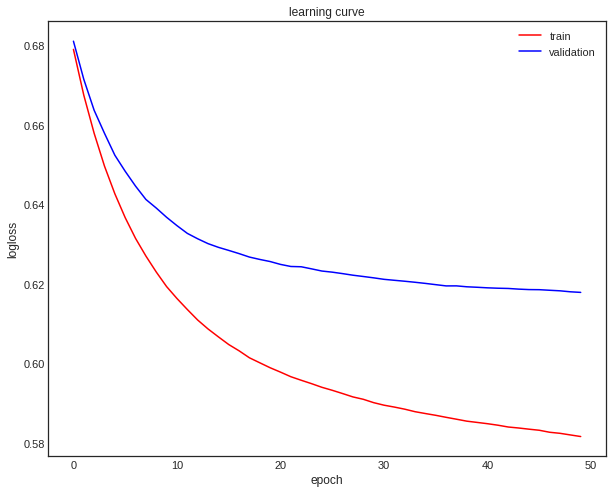

In [62]:
# 训练
lgb_model_single.train(save_learn_curve=True, early_stopping_rounds=20)

In [63]:
# 贝叶斯调参
# 指定需要调参的范围
search_space = {
    'n_estimators': (100, 1000),
    'learning_rate': (0.01, 0.2),
    'max_depth': (4, 6),
    'num_leaves': (31, 64),
    'reg_lambda': (0, 1),
    'reg_alpha': (0, 1),
}
lgb_model_single.optimize_model_param(search_space)

|   iter    |  target   | learni... | max_depth | n_esti... | num_le... | reg_alpha | reg_la... |
-------------------------------------------------------------------------------------------------
|  1        |  0.6651   |  0.04668  |  4.474    |  922.5    |  49.57    |  0.3231   |  0.4765   |
|  2        |  0.6631   |  0.09354  |  5.549    |  808.0    |  49.63    |  0.978    |  0.8621   |
|  3        |  0.6616   |  0.1902   |  5.024    |  471.2    |  40.79    |  0.67     |  0.04638  |
|  4        |  0.6631   |  0.1997   |  4.832    |  474.2    |  35.44    |  0.1994   |  0.2357   |
|  5        |  0.661    |  0.1838   |  5.085    |  599.7    |  52.97    |  0.922    |  0.3604   |
|  6        |  0.6598   |  0.1828   |  5.474    |  731.0    |  58.62    |  0.9046   |  0.5059   |
|  7        |  0.6638   |  0.1435   |  4.025    |  557.0    |  46.92    |  0.2541   |  0.04095  |
|  8        |  0.6653   |  0.09692  |  5.994    |  134.8    |  55.4     |  0.8834   |  0.6633   |
|  9        |  0.664

[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[115]	training's binary_logloss: 0.575668	valid_1's binary_logloss: 0.615859


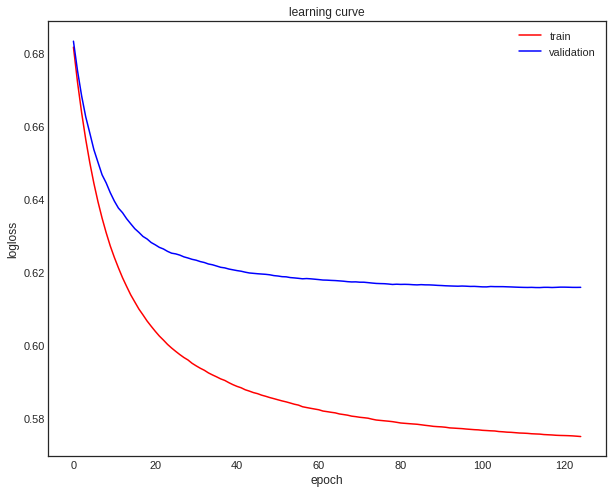

In [64]:
# 贝叶斯调参之后重新训练
lgb_model_single.train(save_learn_curve=True, early_stopping_rounds=10)

In [65]:
# 模型评估，对所有样本打分
result = lgb_model_single.evaluate()
result.head()

train AUC: 0.74784
val AUC: 0.72917
test AUC: 0.72384


,month,label,group,group_random,group_stacking,prob
0,2020-09,0,1,1,0,0.310
1,2020-11,1,-1,-1,-1,0.393
2,2020-10,0,-1,-1,-1,0.441
3,2020-11,0,-1,1,-1,0.725
4,2020-06,0,0,-1,2,0.656


<Figure size 720x576 with 0 Axes>

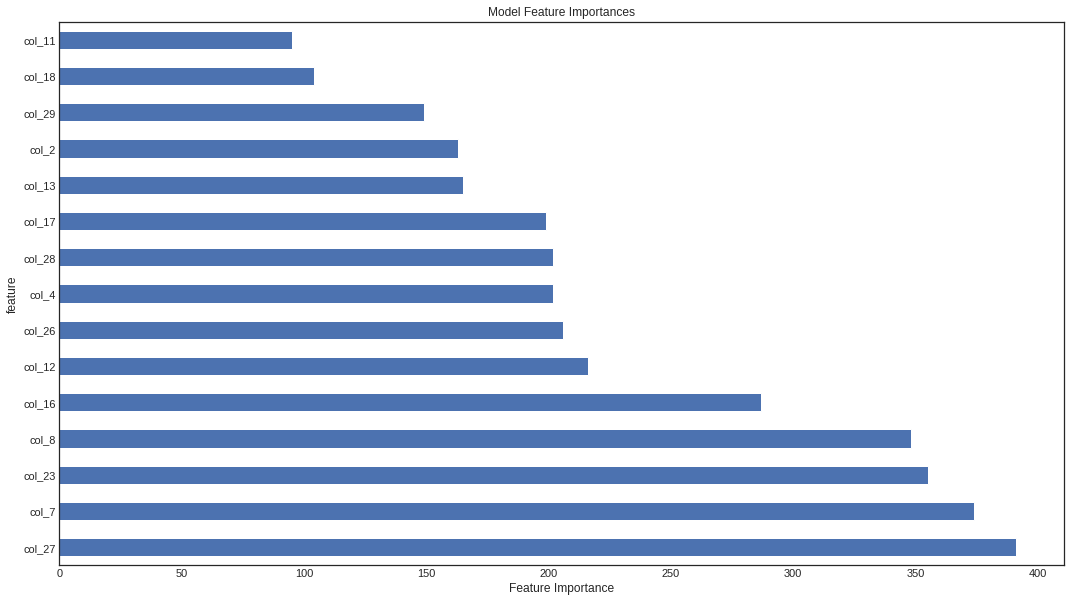

In [66]:
# 模型导出&保存特征重要度
lgb_model_single.export()
lgb_model_single.save_feature_importance(plot=True)

## LGBModelStacking
用于训练LightGBM单模型

参数：
- `data`: 全量数据
- `feature_names`: 输入的特征名列表
- `target`: 目标值的列名，默认为'target'
- `group_col`: 分组列的列名，默认为'group'
- `n_fold`: K折交叉，和样本划分时用的折数保持一致
- `woe_features`: 需要转成woe编码的列，常用于城市名称等类别过多的列，默认为None（**注意：配置此项后只能导出pkl模型，不能导出pmml模型，因为sklearn2pmml不支持自定义的encoder**）
- `out_path`: 结果输出路径，默认为当前目录out
- `model_params`: LightGBM模型参数dict，默认为None,
- `model_name`: 模型名称
- `need_pmml`: 是否需要支持pmml文件导出，默认为True，如果配置了`woe_features`，则需将此参数配置为False

方法&参数：
- `update_model_params`: 更新模型参数
    - `model_params`: 模型参数字典
- `train`: 训练模型
    - `early_stopping_rounds`: 早停轮次
    - `eval_metric`: 用于判断是否早停的评估指标，默认为"binary_logloss"
    - `verbose`: 训练过程中的打印消息，默认为-1
    - `save_learn_curve`: 是否保存训练曲线至输出路径，默认为False
- `export`: 导出模型和特征，如果`need_pmml`为True，将自动导出pmml文件，此外可以选择是否导出成pkl
    - `export_pkl`: 是否导出pkl文件，默认为True
- `evaluate`：给数据集中所有样本打分，并输出（保留数据中剔除feature外的所有列）
- `save_feature_importance`：保存模型的特征重要度得分


In [67]:
out_path = "../res/test_didtool"
model_params = dict(
    boosting_type='gbdt', n_estimators=100, learning_rate=0.1,
    max_depth=5, num_leaves=64, feature_fraction=1, bagging_fraction=1, reg_alpha=1,
    reg_lambda=1, min_data_in_leaf=100, random_state=27,
    class_weight='balanced', verbose=-1
)
features = [col for col in df.columns.values if col not in ('month', 'label', 'group', 'group_random', 'group_stacking')]

# 注意：此处指定的n_fold必须与之前划分数据集时采用的n_fold保持一致
lgb_model_stacking = didtool.LGBModelStacking(df, features, target="label", group_col='group_stacking', n_fold=3, model_params=model_params, out_path=out_path, model_name="test_model_stacking", need_pmml=True)

[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	training's binary_logloss: 0.578739	valid_1's binary_logloss: 0.590989
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	training's binary_logloss: 0.57815	valid_1's binary_logloss: 0.591177
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	training's binary_logloss: 0.578913	valid_1's binary_logloss: 0.589818


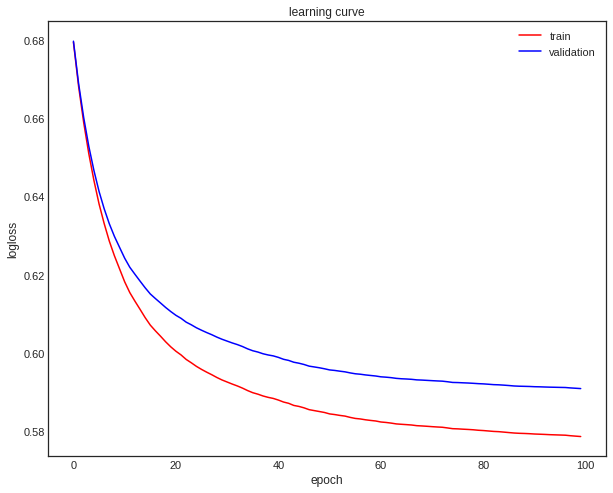

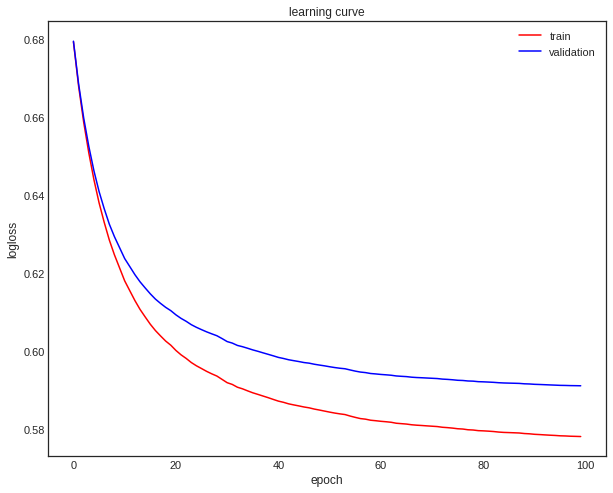

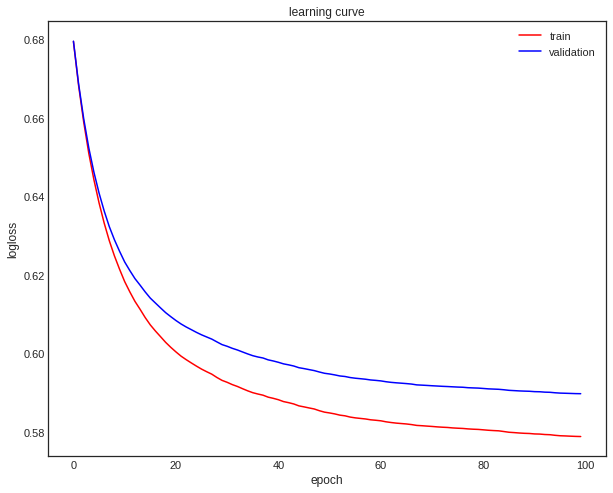

In [68]:
lgb_model_stacking.train(save_learn_curve=True, early_stopping_rounds=20)

In [69]:
# 模型评估，对所有样本打分
# 训练集样本使用第k折模型打分，OOT样本使用所有模型打分的平均值
result = lgb_model_stacking.evaluate()
result.head()


**** model_0 ****
train AUC: 0.74409
val AUC: 0.74200

**** model_1 ****
train AUC: 0.74475
val AUC: 0.74099

**** model_2 ****
train AUC: 0.74366
val AUC: 0.74237

**** model_stacking ****
total train AUC: 0.74171
total test AUC: 0.72527


,month,label,group,group_random,group_stacking,prob_0,prob_1,prob_2,prob
0,2020-09,0,1,1,0,0.309,0.281,0.279,0.309
1,2020-11,1,-1,-1,-1,0.411,0.419,0.409,0.413
2,2020-10,0,-1,-1,-1,0.412,0.390,0.407,0.403
3,2020-11,0,-1,1,-1,0.710,0.722,0.709,0.714
4,2020-06,0,0,-1,2,0.683,0.688,0.675,0.675


<Figure size 720x576 with 0 Axes>

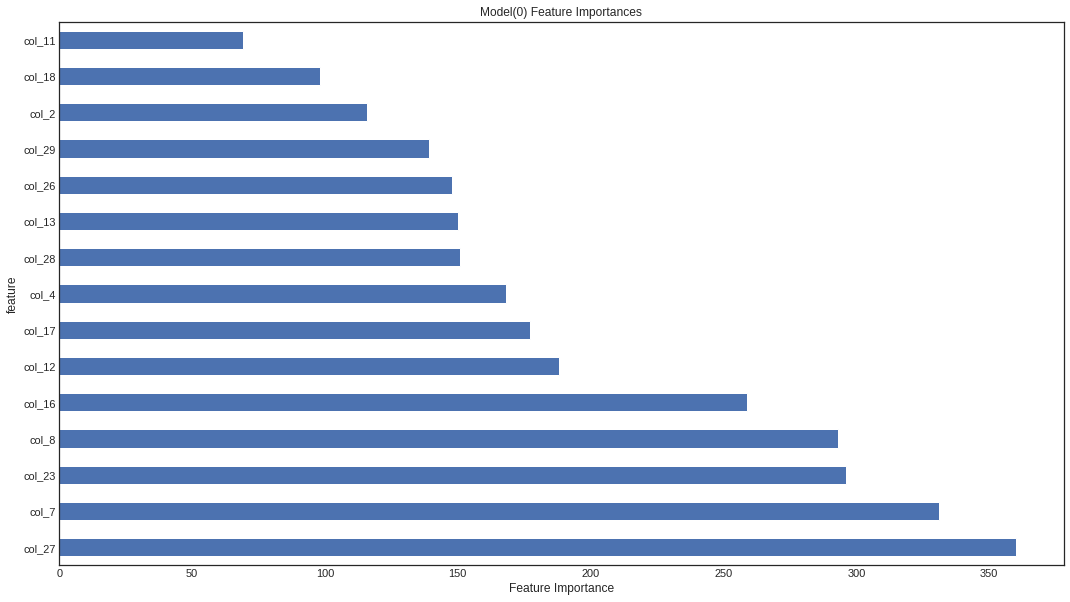

<Figure size 720x576 with 0 Axes>

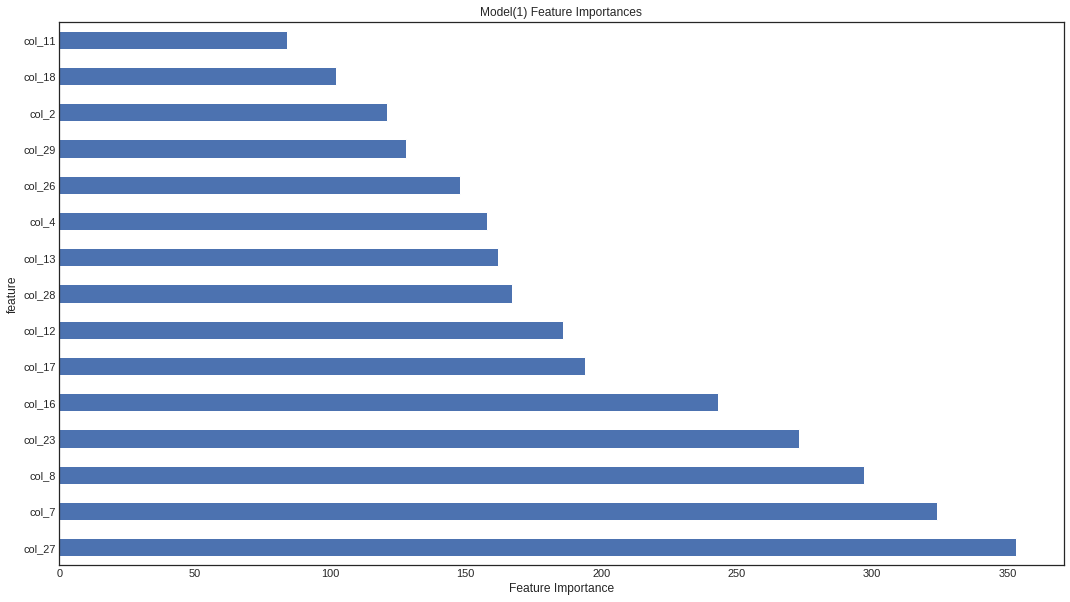

<Figure size 720x576 with 0 Axes>

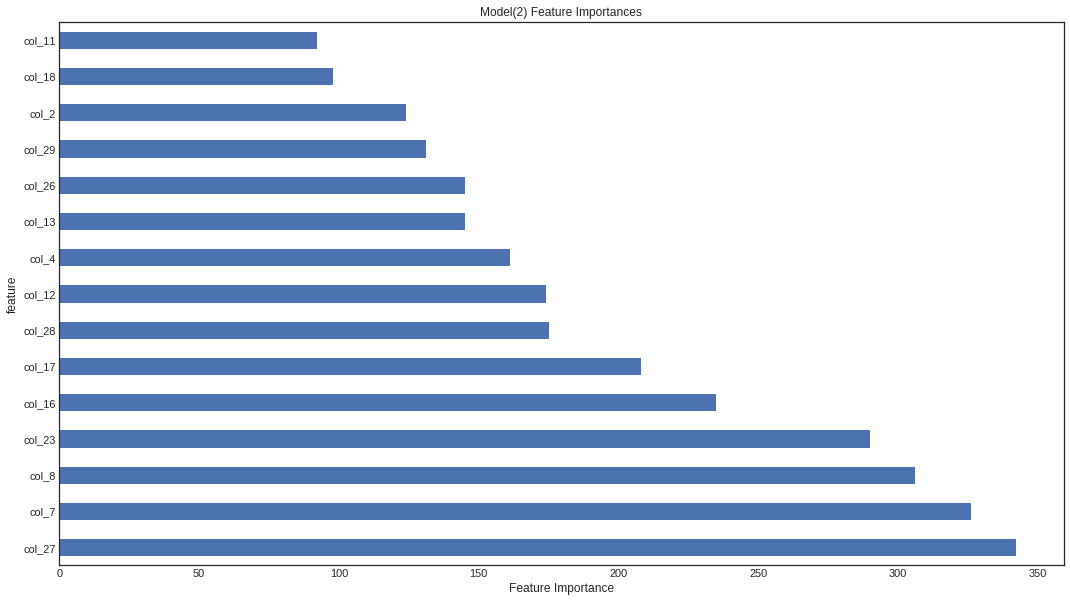

In [70]:
# 模型导出&保存特征重要度
lgb_model_stacking.export()
lgb_model_stacking.save_feature_importance(plot=True)

# 模型评估
常用方法：
- `plot_roc`: 画出roc曲线，计算auc
- `plot_ks`: 画出KS曲线
- `plot_pr_curve`: 画出PR曲线
- `plot_pr_threshold`: 画出精确率和召回率随阈值变化的曲线
- `compare_roc`: 比较多组预测值的ROC曲线，用于不同模型对比
- `distribution`: 画出数据的分布曲线
- `distributions`: 同时画出多组数据的分布曲线
- `psi`: 计算psi指数
- `plot_layer_stability`: 画出分组分箱分布图

In [71]:
# 待评估的数据
oot_res = result[result.group==-1]
oot_res.head()

,month,label,group,group_random,group_stacking,prob_0,prob_1,prob_2,prob
1,2020-11,1,-1,-1,-1,0.411,0.419,0.409,0.413
2,2020-10,0,-1,-1,-1,0.412,0.390,0.407,0.403
3,2020-11,0,-1,1,-1,0.710,0.722,0.709,0.714
5,2020-11,0,-1,0,-1,0.694,0.665,0.678,0.679
8,2020-11,0,-1,1,-1,0.524,0.418,0.542,0.495


## plot_roc
画出roc曲线，计算auc

参数：
- `y_true`: 真实值列表，元素取值0/1
- `y_pred`: 预测值列表
- `out_path`: 如果需要将图片导出，则需指定保存路径，默认为None
- `file_name`: 保存的文件名，仅在指定`out_path`时生效

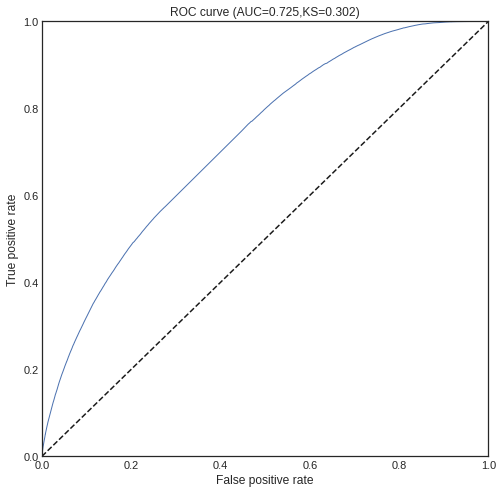

In [72]:
didtool.plot_roc(oot_res['label'], oot_res['prob'])

## plot_ks
画出ks曲线，计算ks值

参数：
- `y_true`: 真实值列表，元素取值0/1
- `y_pred`: 预测值列表
- `out_path`: 如果需要将图片导出，则需指定保存路径，默认为None
- `file_name`: 保存的文件名，仅在指定`out_path`时生效
- `cal_method`: ks的计算方式，默认为"plot_ks_in_cum"，按正负样本累加求和的方式，也可以选择"plot_ks_in_tpr_fpr"，使用TPR和FPR曲线计算

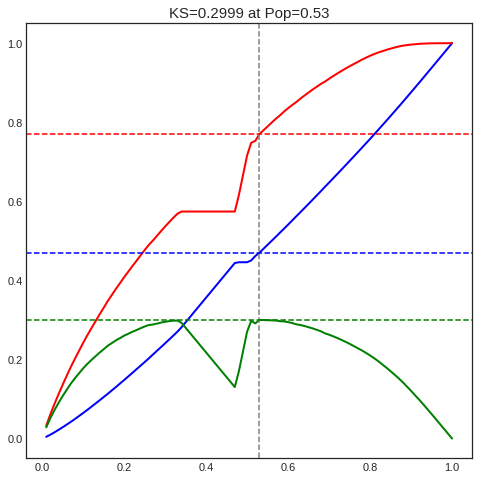

In [73]:
didtool.plot_ks(oot_res['label'], oot_res['prob'])

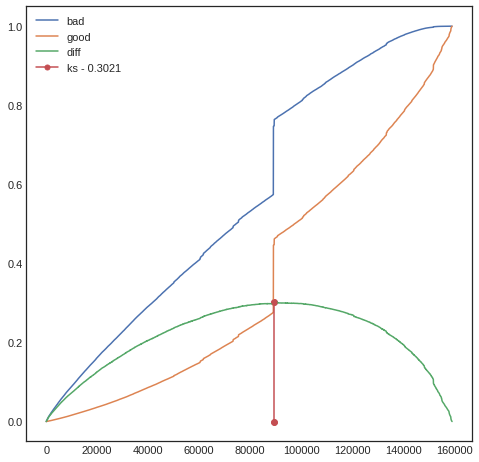

In [74]:
didtool.plot_ks(oot_res['label'], oot_res['prob'], cal_method="plot_ks_in_tpr_fpr")

## plot_pr_curve
画出PR曲线，计算AP值

参数：
- `y_true`: 真实值列表，元素取值0/1
- `y_pred`: 预测值列表
- `out_path`: 如果需要将图片导出，则需指定保存路径，默认为None
- `file_name`: 保存的文件名，仅在指定`out_path`时生效

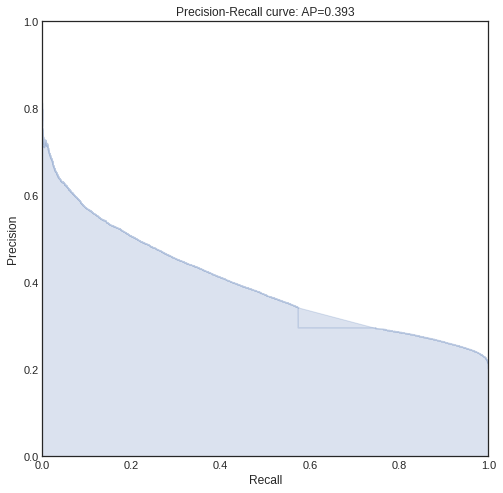

In [75]:
didtool.plot_pr_curve(oot_res['label'], oot_res['prob'])

## plot_pr_threshold
以阈值作为横轴，分别画出精确率和召回率曲线

参数：
- `y_true`: 真实值列表，元素取值0/1
- `y_pred`: 预测值列表
- `out_path`: 如果需要将图片导出，则需指定保存路径，默认为None
- `file_name`: 保存的文件名，仅在指定`out_path`时生效

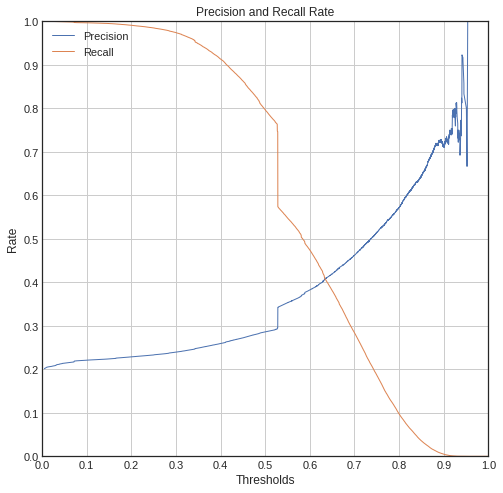

In [76]:
didtool.plot_pr_threshold(oot_res['label'], oot_res['prob'])

## compare_roc
将多组数据的ROC曲线画在一张图里

参数：
- `y_true_list`: 多个分组的真实值列表，元素取值0/1
- `y_pred_list`: 多个分组的预测值列表
- `model_name_list`: 多个分组名
- `out_path`: 如果需要将图片导出，则需指定保存路径，默认为None
- `file_name`: 保存的文件名，仅在指定`out_path`时生效

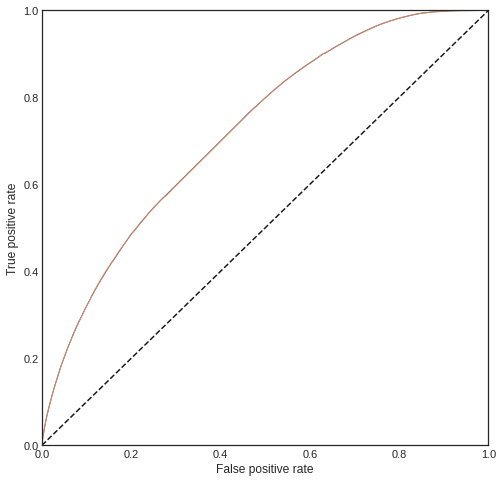

In [77]:
# 比较prob_0和prob_1
y_true_list = [oot_res.label, oot_res.label]
y_pred_list = [oot_res.prob_0, oot_res.prob_1]
labels = ['model_0', 'model_1']
didtool.compare_roc(y_true_list, y_pred_list, labels)

## distribution
画出数据的分布曲线

参数：
- `x`: 输入数据
- `bins`: 分箱个数，可以不指定，默认为None
- `out_path`: 如果需要将图片导出，则需指定保存路径，默认为None
- `file_name`: 保存的文件名，仅在指定`out_path`时生效

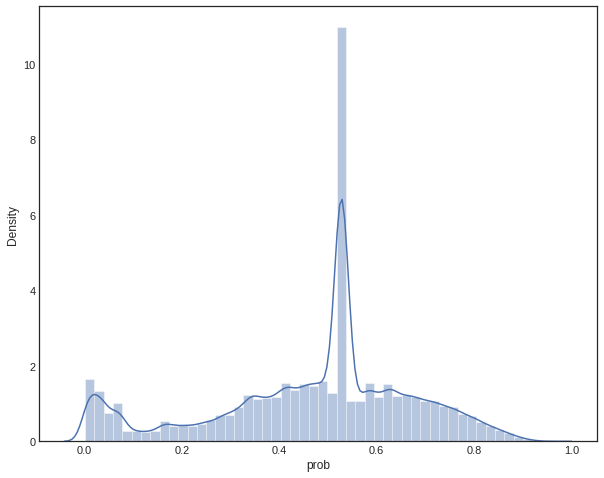

In [78]:
didtool.distribution(oot_res['prob'], bins=50)

## distributions
同时画出多组数据的分布曲线

参数：
- `x_list`: 输入数据，以list形式输入多个数据
- `bins`: 分箱个数，可以不指定，默认为None
- `out_path`: 如果需要将图片导出，则需指定保存路径，默认为None
- `file_name`: 保存的文件名，仅在指定`out_path`时生效

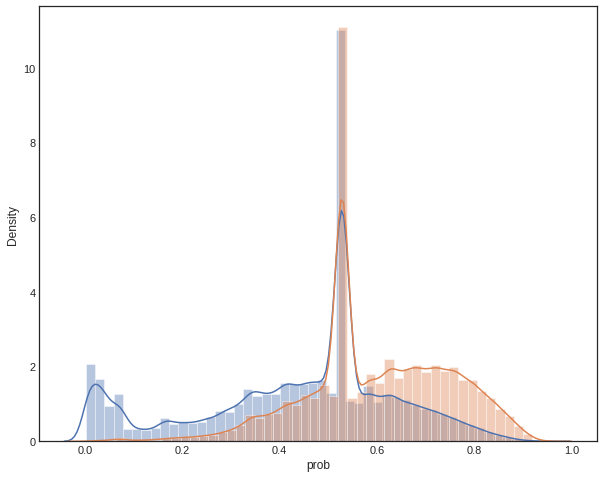

In [79]:
didtool.distributions([oot_res[oot_res.label==0]['prob'], oot_res[oot_res.label==1]['prob']], bins=50)

## psi
对期望数据进行等距分箱，并用相同的分割点对实际数据进行分箱，对比数据分布情况，计算PSI判断数据是否稳定

参数：
- `expected_array` : 期望数据
- `actual_array`: 实际数据
- `n_bins` : 分箱数，默认为0
- `plot` : 是否画出期望数据和实际数据的分箱分布图，默认为False
- `is_continuous` : 输入数据是否为连续值，默认为True

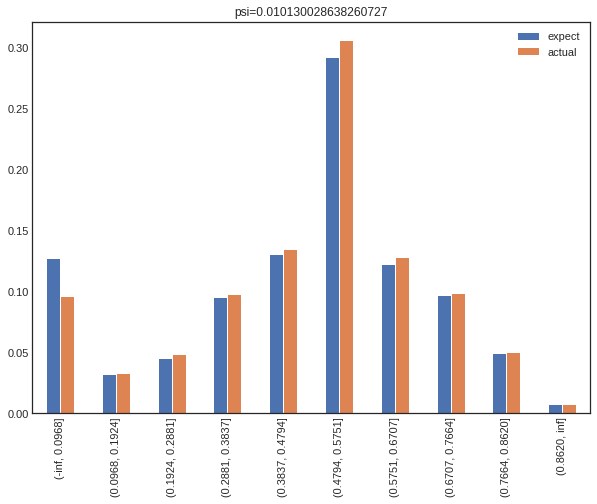

0.010130028638260727

In [80]:
# 期望数据为训练集的打分分布，实际数据为OOT集的数据分布
didtool.psi(result[result.group>0]['prob'], oot_res['prob'], plot=True)

**TIPS：** 还可以使用`psi_all`计算所有月份的psi

In [81]:
didtool.psi_all(result, ['prob'], expected_data=result[result.month < '2020-10'])

,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11
prob,0.005,0.002,0.001,0.003,0.015,0.028


## plot_layer_stability
画出分组分箱分布图

参数：
- `probs`: 预测值
- `groups`: 分组值
- `labels`: 真实值
- `n_bins`: 分箱个数，可以不指定，默认为10
- `out_path`: 如果需要将图片导出，则需指定保存路径，默认为None
- `file_name`: 保存的文件名，仅在指定`out_path`时生效

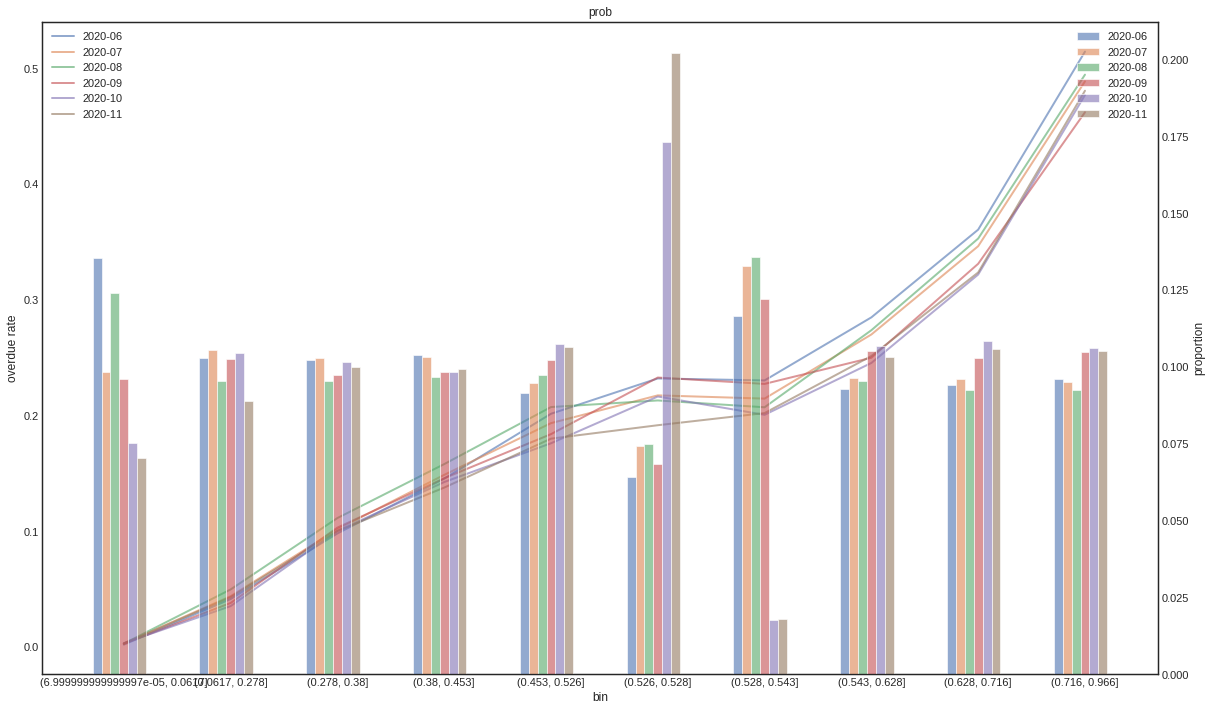

In [82]:
didtool.plot_layer_stability(result['prob'], result['month'], result['label'])

# 评分卡映射
`ScoreCardTransformer`：将概率值分箱后计算ODDS（好坏比），然后映射成整数值

参数：
- `n_bins`: 分箱数，默认为20
- `standard_score`: 标准分，当odds等于`standard_odds`时的分数
- `standard_odds`: 标准odds，odds定义为good_rate/bad_rate
- `pdo`: 分数步长，当odds翻倍时，对应的整数分应该增加的步长
- `bad_flag`: label为1时是否表示坏用户，默认为True

方法&参数：
- `fit`: 训练评分映射器
- `transform`：将概率值转换成整数分数值
- `plot_bins`: 画出各个分箱情况
- `export_mapping`: 导出分数映射文件

In [83]:
score_transformer = didtool.ScoreCardTransformer(n_bins=10, standard_score=600, standard_odds=0.01, pdo=40, bad_flag=False)
score_transformer.fit(result['prob'].values, result['label'].values)
score = score_transformer.transform(result['prob'].values)
score

array([733, 762, 760, ..., 769, 843, 790])

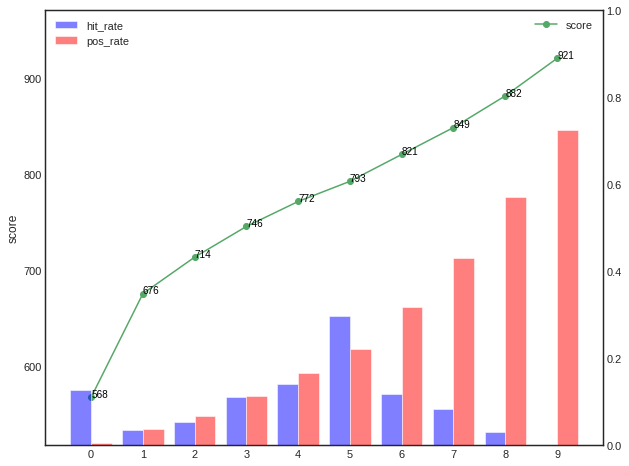

In [84]:
score_transformer.plot_bins()

In [85]:
score_transformer.export_mapping('../res/test_didtool', file_name='map_score_card.csv')